<a href="https://colab.research.google.com/github/kridtapon/Aroon-MACD-Breakout-Strategy/blob/main/Aroon_MACD_Breakout_Strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
pip install vectorbt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.5/527.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 62.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 43.4 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.43.0
    Uninstalling llvmlite-0.43.0:
      Successfully uninstalled llvmlite-0.43.0
  Attempting uninstall: numba
    Found existing installation: numba 0.60.0
    Uninstalling numba-0.60.0:
      Successfully uninsta

In [40]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Aroon Indicator
def aroon_indicator(df, period=14):
    df['Aroon_Up'] = ((df['High'].rolling(window=period).apply(lambda x: np.argmax(x) + 1) / period) * 100)
    df['Aroon_Down'] = ((df['Low'].rolling(window=period).apply(lambda x: np.argmin(x) + 1) / period) * 100)
    return df['Aroon_Up'], df['Aroon_Down']

# Define the stock symbol and time period
symbol = 'RCL' # APO RCL SYF UAL
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close','Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate Aroon and Darvas Box
df['Aroon_Up'], df['Aroon_Down'] = aroon_indicator(df, period=15)

# Define entry and exit signals based on Aroon and Darvas Box
df['Entry'] = (
    (df['Aroon_Down'] < df['Aroon_Up']) #&  # Aroon Down < Aroon Up
)

df['Exit'] = (
    (df['Aroon_Down'] > df['Aroon_Up']) #&  # Aroon Down > Aroon Up
)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()

[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                           812042.003564
Total Return [%]                       712.042004
Benchmark Return [%]                    71.325669
Max Gross Exposure [%]                      100.0
Total Fees Paid                      17005.066887
Max Drawdown [%]                         42.11246
Max Drawdown Duration                       568.0
Total Trades                                   34
Total Closed Trades                            34
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                            55.882353
Best Trade [%]                          51.620361
Worst Trade [%]                        -14.487905
Avg Winning Trade [%]                   18.365088
Avg Losing Trade [%]                    -6.227924


In [4]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Aroon Indicator
def aroon_indicator(df, period=14):
    df['Aroon_Up'] = ((df['High'].rolling(window=period).apply(lambda x: np.argmax(x) + 1) / period) * 100)
    df['Aroon_Down'] = ((df['Low'].rolling(window=period).apply(lambda x: np.argmin(x) + 1) / period) * 100)
    return df['Aroon_Up'], df['Aroon_Down']

# MACD Indicator
def macd(df, fast_period=12, slow_period=26, signal_period=9):
    df['EMA_Fast'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA_Slow'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA_Fast'] - df['EMA_Slow']
    df['MACD_Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
    return df['MACD'], df['MACD_Signal']

# Define the stock symbol and time period
symbol = 'RCL'  # APO RCL SYF UAL
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Calculate Aroon and MACD
df['Aroon_Up'], df['Aroon_Down'] = aroon_indicator(df, period=15)
df['MACD'], df['MACD_Signal'] = macd(df,fast_period=16,slow_period=26,signal_period=12)

# Define entry and exit signals based on Aroon and MACD
df['Entry'] = (
    (df['Aroon_Down'] < df['Aroon_Up']) &  # Aroon Down < Aroon Up
    (df['MACD'] > df['MACD_Signal'])       # MACD Line crosses above Signal Line
)

df['Exit'] = (
    (df['Aroon_Down'] > df['Aroon_Up']) &  # Aroon Down > Aroon Up
    (df['MACD'] < df['MACD_Signal'])       # MACD Line crosses below Signal Line
)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Convert signals to boolean arrays
entries = df['Entry'].to_numpy()
exits = df['Exit'].to_numpy()

# Backtest using vectorbt
portfolio = vbt.Portfolio.from_signals(
    close=df['Close'],
    entries=entries,
    exits=exits,
    init_cash=100_000,
    fees=0.001
)

# Display performance metrics
print(portfolio.stats())

# Plot equity curve
portfolio.plot().show()


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Start                         2020-01-02 00:00:00
End                           2024-12-31 00:00:00
Period                                       1258
Start Value                              100000.0
End Value                          1131921.168638
Total Return [%]                      1031.921169
Benchmark Return [%]                    71.325669
Max Gross Exposure [%]                      100.0
Total Fees Paid                      19330.200829
Max Drawdown [%]                        46.657682
Max Drawdown Duration                       551.0
Total Trades                                   25
Total Closed Trades                            25
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                 60.0
Best Trade [%]                         100.940511
Worst Trade [%]                          -16.6556
Avg Winning Trade [%]                   25.265982
Avg Losing Trade [%]                     -6.73616


In [5]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt
from itertools import product

# Aroon Indicator
def aroon_indicator(df, period=14):
    df['Aroon_Up'] = ((df['High'].rolling(window=period).apply(lambda x: np.argmax(x) + 1) / period) * 100)
    df['Aroon_Down'] = ((df['Low'].rolling(window=period).apply(lambda x: np.argmin(x) + 1) / period) * 100)
    return df['Aroon_Up'], df['Aroon_Down']

# MACD Indicator
def macd(df, fast_period=12, slow_period=26, signal_period=9):
    df['EMA_Fast'] = df['Close'].ewm(span=fast_period, adjust=False).mean()
    df['EMA_Slow'] = df['Close'].ewm(span=slow_period, adjust=False).mean()
    df['MACD'] = df['EMA_Fast'] - df['EMA_Slow']
    df['MACD_Signal'] = df['MACD'].ewm(span=signal_period, adjust=False).mean()
    return df['MACD'], df['MACD_Signal']

# Download the stock data
symbol = 'RCL'  # Replace with your symbol
start_date = '2019-01-01'
end_date = '2025-01-01'

df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Define parameter ranges
aroon_periods = [10, 15, 20]
macd_fast_periods = [8, 12, 16]
macd_slow_periods = [20, 26, 32]
macd_signal_periods = [6, 9, 12]

# Prepare to store results
results = []

# Grid search through parameter combinations
for aroon_period, fast_period, slow_period, signal_period in product(aroon_periods, macd_fast_periods, macd_slow_periods, macd_signal_periods):
    # Calculate indicators with current parameters
    df['Aroon_Up'], df['Aroon_Down'] = aroon_indicator(df, period=aroon_period)
    df['MACD'], df['MACD_Signal'] = macd(df, fast_period=fast_period, slow_period=slow_period, signal_period=signal_period)

    # Define entry and exit signals
    df['Entry'] = (
        (df['Aroon_Down'] < df['Aroon_Up']) &
        (df['MACD'] > df['MACD_Signal'])
    )
    df['Exit'] = (
        (df['Aroon_Down'] > df['Aroon_Up']) &
        (df['MACD'] < df['MACD_Signal'])
    )

    # Filter data for the test period
    test_df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]
    entries = test_df['Entry'].to_numpy()
    exits = test_df['Exit'].to_numpy()

    # Backtest
    portfolio = vbt.Portfolio.from_signals(
        close=test_df['Close'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001
    )

    # Record results
    stats = portfolio.stats()
    results.append({
        'aroon_period': aroon_period,
        'macd_fast_period': fast_period,
        'macd_slow_period': slow_period,
        'macd_signal_period': signal_period,
        'total_return': stats['Total Return [%]']
    })

# Convert results to a DataFrame for analysis
results_df = pd.DataFrame(results)

# Find the best parameters
best_params = results_df.sort_values(by='total_return', ascending=False).iloc[0]
print("Best Parameters:")
print(best_params)


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sharpe_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'calmar_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'omega_ratio' requires frequency to be set

/usr/local/lib/python3.10/dist-packages/vectorbt/generic/stats_builder.py:396: UserWarning:

Metric 'sortino_ratio' requires frequency to be set



Best Parameters:
aroon_period            15.000000
macd_fast_period        16.000000
macd_slow_period        26.000000
macd_signal_period      12.000000
total_return          1031.921169
Name: 50, dtype: float64


[*********************100%***********************]  1 of 1 completed


Best period: 15, Total Return: 744.85%


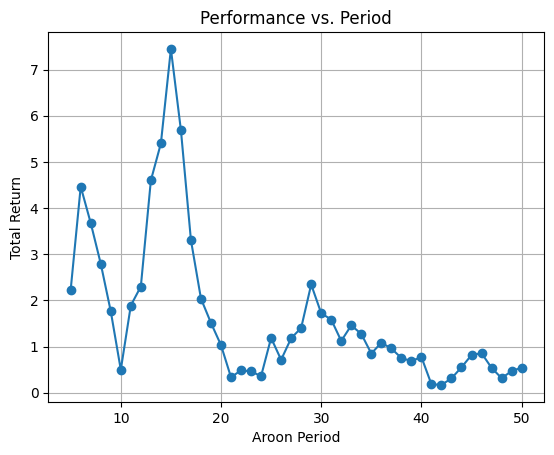

In [39]:
import numpy as np
import pandas as pd
import yfinance as yf
import vectorbt as vbt

# Aroon Indicator
def aroon_indicator(df, period=14):
    df['Aroon_Up'] = ((df['High'].rolling(window=period).apply(lambda x: np.argmax(x) + 1) / period) * 100)
    df['Aroon_Down'] = ((df['Low'].rolling(window=period).apply(lambda x: np.argmin(x) + 1) / period) * 100)
    return df['Aroon_Up'], df['Aroon_Down']

# Define the stock symbol and time period
symbol = 'RCL'  # APO RCL SYF UAL
start_date = '2019-01-01'
end_date = '2025-01-01'

# Download the data
df = yf.download(symbol, start=start_date, end=end_date)
df.columns = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']
df.ffill(inplace=True)

# Filter data for the test period (2020-2025)
df = df[(df.index.year >= 2020) & (df.index.year <= 2025)]

# Optimization loop for the best period
best_period = None
best_metric = -np.inf
performance_results = []

for period in range(5, 51):  # Test periods from 5 to 50
    # Calculate Aroon
    df['Aroon_Up'], df['Aroon_Down'] = aroon_indicator(df, period=period)

    # Define entry and exit signals
    df['Entry'] = (df['Aroon_Down'] < df['Aroon_Up'])
    df['Exit'] = (df['Aroon_Down'] > df['Aroon_Up'])

    # Convert signals to boolean arrays
    entries = df['Entry'].to_numpy()
    exits = df['Exit'].to_numpy()

    # Backtest using vectorbt
    portfolio = vbt.Portfolio.from_signals(
        close=df['Close'],
        entries=entries,
        exits=exits,
        init_cash=100_000,
        fees=0.001
    )

    # Evaluate a performance metric (e.g., total return)
    total_return = portfolio.total_return()
    performance_results.append((period, total_return))

    # Update the best period if this one is better
    if total_return > best_metric:
        best_metric = total_return
        best_period = period

# Print the best period and corresponding performance
print(f"Best period: {best_period}, Total Return: {best_metric:.2%}")

# Optional: Plot the performance results
import matplotlib.pyplot as plt
periods, returns = zip(*performance_results)
plt.plot(periods, returns, marker='o')
plt.title('Performance vs. Period')
plt.xlabel('Aroon Period')
plt.ylabel('Total Return')
plt.grid()
plt.show()
